In [1]:
# Transforming the ALFRED dataset
from utils import *

ALFRED_JSON_PATTERN = '../datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json' 
train_dataset = load_next_alfred_data(ALFRED_JSON_PATTERN)
print('train dataset size: ', len(train_dataset))
print('%3f kb' % (sys.getsizeof(train_dataset) / 1024.0))


100%|██████████| 6574/6574 [00:19<00:00, 338.30it/s]

train dataset size:  6568
53.296875 kb


In [2]:
# Filter dataset
import random

def filtered_dataset_copy(alfred_data, scene):
    data_copy = alfred_data.copy()

    def filter_scene(x):
        return x[1]['floor_plan'] == scene

    data_copy = list(filter(filter_scene, data_copy))      
    
    # Filter puncuation
    for task in data_copy:
        for traj in task[0]:
            for instruction in traj['instructions']:
                for word_idx, word in enumerate(instruction['instruction']):
                    invalid_word = False
                    if word == '.' or word == ',' or word == '\'':
                        invalid_word = True
                    
                    if invalid_word:
                        del instruction['instruction'][word_idx]
                    
                    #print(instruction['instruction'])
            #assert False    
    
    return data_copy

dataset25 = filtered_dataset_copy(train_dataset, 'FloorPlan25')
# A little random sample for testing
print('dataset samples: ', len(dataset25))
for i in range(1):
    print('*' * 20)
    example = dataset25[0] #random.choice(dataset25)
    #print(example[1]['floor_plan'])
    #print(example[1]['object_poses'])
    print(example[1]['task_id'])
    for j in example[0]:
        print('-' * 20)
        print(j['task_desc'])
        print(j['instructions'])

dataset samples:  123
********************
trial_T20190907_062036_745419
--------------------
Slice a vegetable from the fridge in the sink.
[{'instruction': ['turn', 'right', 'and', 'walk', 'to', 'the', 'microwave', 'on', 'the', 'right'], 'action': 'GotoLocation', 'argument_1': 'microwave', 'argument_2': '<unk>'}, {'instruction': ['open', 'the', 'door', 'on', 'the', 'microwave', 'and', 'take', 'the', 'dark', 'colored', 'vegetable', 'close', 'the', 'door'], 'action': 'PickupObject', 'argument_1': 'potato', 'argument_2': '<unk>'}, {'instruction': ['turn', 'left', 'and', 'walk', 'to', 'the', 'sink'], 'action': 'GotoLocation', 'argument_1': 'sinkbasin', 'argument_2': '<unk>'}, {'instruction': ['put', 'the', 'vegetable', 'in', 'the', 'sink'], 'action': 'PutObject', 'argument_1': 'potato', 'argument_2': 'sinkbasin'}, {'instruction': ['turn', 'right', 'then', 'turn', 'back', 'left', 'to', 'face', 'the', 'sink'], 'action': 'GotoLocation', 'argument_1': 'countertop', 'argument_2': '<unk>'}, {'

# Instruction Dot Test
Use the dot product between words and semantic graph. 

TODO:
* Use cosine similarity for scoring, instead of dot product. [DONE]
* Normalise affordance features after adding parent representions. [DONE, Note: I averaged affordance features by dividing by 2.0]
* Remove puncuation from the instructions. [DONE, removes ('), (,), (.)]
* Remove / Control instruction quality by thresholding votes [DONE, during processing removes any instructions without unanimous votes]
* New test: Only use environments where all objects already exist within the graph. [DONE]
* Pie chart showing percents on target action [DONE]

[Priority]<br>

Visualisation patch:
* Replace "Most failed actions" with pie chart showing test action composition
* Histogram on instruction length and performance ratio [Priority]
* Bar chart of cosine scores for a single trajectory [IGNORE, only works on local (small) graphs]
* Add interactive prompt mode. [DONE]

Performance patch:
* Seperate function into modular groups.
* Use vibs codebook lookup to store indices instead of word vectors. Only change pickle loading functions.
* DO NOT use hash to save files. Hash resets on python interpreters for security. Use cryptohash if required. Alternatively, just use the filenames if possible? [DONE]

Experiments TODO:
* DOCUMENT ALL TESTS IN THEIR FOLDERS WITH SOURCE DATA [PRIORITY]
* Redo trajectory test: Cancel trajectories as soon as a single instruction fails
* Redo test: On hot vectors

Future:
* Instead of adding object features to affordance features score them seperately on nouns and verbs respectively then sum them together for a final score. Disregard determiner words and puncuation. 
* Add a distance scaling factor around the robot_node after the first instruction.
* Add all affordances
* Assure that actions ARE performed. This means sometimes we have to scan our immediate surroundings to perform actions on. Example:Target: go -> sinkbasin, Actual: go -> sinkbasin [True] PickupObject False  Fork|-01.97|+00.70|+00.30 is not visible. Target: pick -> fork, Actual: pick -> fork [True]
* Analyse the mindmeld NLP pipeline for seeing how far we can make this a real product project. I.e. Intent classification. Entity classification. Entity Role Assignment. WSB, POS, NER, entity resolution. 


In [3]:
from models import *

m = CosineModel()
class T:
    x = torch.randn(4,10)
    edge_index = torch.randn(2, 4)

t = T()
m(t, torch.randn(10,10))


(tensor([[-0.8755],
         [ 0.6068],
         [-0.2811],
         [ 0.3615]]),
 [tensor(3),
  tensor(0),
  tensor(1),
  tensor(1),
  tensor(3),
  tensor(0),
  tensor(1),
  tensor(3),
  tensor(3),
  tensor(0)])

In [10]:
import ai2thor
import ai2thor.controller
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import torchtext

import pandas as pd
import json, pickle, time
from tqdm.notebook import trange, tqdm

print(ai2thor.__version__)
# word_vec = torchtext.vocab.FastText()
# controller = ai2thor.controller.Controller(scene='FloorPlan29', grid_size=0.25, visibilityDistance=0.75, quality='Very Low', headless=False)   
controller = ai2thor.controller.Controller() #dict(scene='FloorPlan25', grid_size=0.25, visibilityDistance=0.75)) #, quality='Very Low', headless=True))
controller.start()
controller.step(dict(action='Initialize', headless=True, visibilityDistance=3.0))
print('Passing...')
event = controller.step(dict(action='Pass'))
print('Resetting...')
controller.reset('FloorPlan25')

%run scene_graph.ipynb
%run thorEnvironment.ipynb

import os
import random
import networkx as nx
import matplotlib.pyplot as plt
import copy

from utils import *

# Seed for reproduceability
np.random.seed(42)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using: ',device)

# Experiment parameters
debug_instructions = False
debug_scores = False
debug_log = True
subset = dataset25[:]
model = CosineModel().to(device)

# The test is for a multiple instructions intended to be executed over multiple timesteps of length 1
max_timesteps = 1 # TODO: Consider increasing to increase performance, niko used 10 i think.
reward = []
used_timesteps = []
trajectory_success = []
instruction_success = []
task_number = 0

# Experiment Log
if debug_log:
    debug_log_file = open('baseline_debug_log.tsv', 'w')
    debug_log_file.write("scene \t instruction \t expected_object \t expected_affordance \t actual_object \t actual_affordance \t success\n")

# run for each instruction in a task
for task in subset:
    trajectories, scene = task
    
    scene_name = "FloorPlan%d" % scene['scene_num']
    task_id = scene['task_id']
    object_poses = scene['object_poses']
    object_toggles = scene['object_toggles']
    dirty_and_empty = scene['dirty_and_empty']
    init_action = scene['init_action']
    
    # ALFRED has a custom initialised scene for each task
    # This is expensive, every task requires new initalisations and therefore new explorations
    environment_file = "../saved_environments/{}_{}.pickle".format(scene_name, task_id)
    
    episode = {'log_probs':[], 'rewards':[], 'timesteps':0, 'entropy':[]}
    done = False
    t = 0
    task_number += 1
    print(" --- %d / %d --- " % (task_number, len(subset)))
    
    for traj_idx, traj in enumerate(trajectories):
        # Each trajectory in a task uses the same environment but must be reset
        # each trajectory.
        controller.reset(scene_name)
        env = ThorEnvironment(controller=controller)
        
        if os.path.isfile(environment_file):
            # load file, if exists
            thor_restore(init_action, object_poses, object_toggles, dirty_and_empty)
            print('Loading environment...')
            env.graph = env.graph.from_pickle(environment_file)
            if not hasattr(env.graph, 'robot_node'):
                env.graph.setup()
            print('Done')
        else:
            # explore and save
            thor_restore(init_action, object_poses, object_toggles, dirty_and_empty)
            print('Exploring environment...')
            env.explore_environment()
            env.graph.setup()
            print('Saving environment...')
            env.graph.to_pickle(environment_file)
            print('Done')
        
        ###########################################################
        # The following continue statement is here to make sure all
        # we are doing is exploring environments for caching.
        # Exploring and then using those graphs could (should) cause
        # this script to crash right now. So instead ill just explore
        # then once that is done I will fix the crash code where we 
        # use the graph. Since the graphs will be cached testing
        # will be quicker!
        ###########################################################
        #continue
        #draw_graph(env.graph)
        #assert False
        
        complete_trajectory = True
        
        if not valid_trajectory(env, traj):
            print('[CHECK] Invalid trajectory. Skipping...')
            continue
        else:
            print('[CHECK] Valid Trajectory!')
        
        if debug_instructions:
            print("Task Trajectory: %d / %d (%d instructions)" % (traj_idx+1, len(trajectories), len(traj['instructions'])))
            print('High level objective: %s | Task Num: %s' % (traj['task_desc'], task_id))
        
        for inst_idx, instruction in enumerate(traj['instructions']):
            if debug_instructions:
                print('-----> Instruction %d / %d' % (inst_idx + 1, len(traj['instructions'])))            
            
            target_object = instruction['argument_1']
            target_affordance = instruction['action']
                        
            if True:
                if debug_instructions:
                    print("Target affordance: %s -> %s\nTarget Instruction: %s" % (instruction['action'], target_object, ' '.join(instruction['instruction'])))
                target_embedding = [env.graph.word2vec(word.lower()) for word in instruction['instruction']]
            else:
                # Sanity check for "ground truth" instructions
                sanity_check_instruction = ['pick', target_object] # WARNING: If the task affordance is chance so shall the 'pick' verb.
                if debug_instructions:
                    print("Target object: %s\nTarget Instruction: %s" % (target_object, ' '.join(sanity_check_instruction)))
                target_embedding = [env.graph.word2vec(word.lower()) for word in sanity_check_instruction]
            

            #done = False
            for timestep in range(max_timesteps):
                
                env.graph.to_torch_graph()

                # Experimental, adds the object features to the affordances
                object_smooth_graph = add_object_features(env.graph)

                # run the policy network
                target = torch.tensor(target_embedding, dtype=torch.float).to(device)
                #logits = model(env.graph._torch_graph.to(device), target).t()
                logits, max_affordances = model(object_smooth_graph, target)
                logits = logits.t()
                
                # we only care about the affordance nodes, so set the logits of all other nodes to something very small
                mask = torch.tensor(env.graph._torch_affordance_mask==0, dtype=torch.bool).view(1,-1).to(device)
                logits[mask] = -1000
                
                # Debug model scores
                if debug_scores:
                    node_names = []
                    for n in max_affordances:
                        if env.graph.nodes[n.item()]['node_type'] == 'affordance':
                            node_names.append(env.graph.nodes[n.item()]['affordance'])
                        elif env.graph.nodes[n.item()]['node_type'] == 'object':
                            node_names.append(env.graph.nodes[n.item()]['obj'])
                    graph_word_scores([word.lower() for word in instruction['instruction']], node_names)
                
                
                # sample an action from the output of the model
                action = torch.argmax(logits)
                affordance = env.graph.from_torch_id(action.item())
                
                correct_affordance = False
                actual_affordance = env.graph.nodes[affordance]['affordance']
                                
                if actual_affordance == normalize_action_name(target_affordance):
                    correct_affordance = True
                
                r = 0.0
                succ, pred = env.graph.get_related_objects(affordance)
                
                correct_object = False
                actual_object = None
                
                if not pred is None:
                    for n in pred:
                        actual_object = env.graph.nodes[n]['obj'] 
                        if actual_object == target_object:
                            if correct_affordance:
                                r = 1.0
                                #done = True
                                correct_object = True
                                env.step(action.item()) # An Action is an affordance in the graph
                                # TODO: If action cannot be executed, break loop and print error. 
                                break
                
                print("Target: %s -> %s \t Actual: %s -> %s [%s]" % (normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_affordance and correct_object))
                
                if correct_affordance and correct_object:
                    instruction_success.append((1.0, normalize_action_name(target_affordance)))
                else:
                    complete_trajectory = False
                    instruction_success.append((0.0, normalize_action_name(target_affordance)))
                    
                if debug_log:
                    debug_log_file.write("%s\t%s\t%s\t%s\t%s\t%s\t%s\n" % (scene_name, ' '.join(instruction['instruction']), normalize_action_name(target_affordance), target_object, actual_affordance, actual_object, correct_object and correct_affordance))
                
                episode['rewards'].append(r)
                episode['timesteps'] = t
        
        if complete_trajectory:
            trajectory_success.append(1.0)
        else:
            trajectory_success.append(0.0)
    
    # === end of an episode ===
    used_timesteps.append(t)
    
    reward.append(np.sum(episode['rewards']))

if debug_log:
    debug_log_file.close()

2.1.0
Passing...
Resetting...
Using:  cpu
 --- 1 / 123 --- 
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "open the door on the microwave and take the dark colored vegetable close the door" Target Not Found: [potato]
[CHECK] Invalid trajectory. Skipping...
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "take the potato out of the microwave" Target Not Found: [potato]
[CHECK] Invalid trajectory. Skipping...
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "open the microwave door and remove the sweet potato that is in the microwave then close the door" Target Not Found: [potato]
[CHECK] Invalid trajectory. Skipping...
 --- 2 / 123 --- 
Loading environment...
Do

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Target: go -> countertop 	 Actual: go -> sinkbasin [False]
PickupObject False Knife|-02.96|+00.85|+00.13 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> potato 	 Actual: put -> sinkbasin [False]
SliceObject False object not found: Potato|-01.86|+00.74|+00.21
Target: slice -> potato 	 Actual: slice -> potato [True]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
PickupObject False Knife|-02.96|+00.85|+00.13 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> potato 	 Actual: put -> sinkbasin [False]
Target: slice -> potato 	 Actual: pick -> knife [False]
 --- 3 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Fork|-00.17|+00.82|+01.21 is not visible.
Target: pick -> fork 	 Actual: pick -> fork [True]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target:

Target: go -> fridge 	 Actual: close -> fridge [False]
Target: pick -> tomato 	 Actual: open -> drawer [False]
Target: go -> microwave 	 Actual: close -> fridge [False]
zero word: 3
Target: heat -> tomato 	 Actual: open -> fridge [False]
Target: go -> garbagecan 	 Actual: go -> window [False]
Target: put -> tomato 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> countertop [True]
PickupObject False Knife|-02.66|+00.82|+00.56 is not visible.
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> tomato 	 Actual: go -> fridge [False]
SliceObject False object not found: Tomato|-02.50|+00.87|+00.79
Target: slice -> tomato 	 Actual: slice -> tomato [True]
Target: go -> fridge 	 Actual: break -> window [False]
Target: put -> knife 	 Actual: put -> fridge [False]
Target: go -> fridge 	 Actual: break -> window [False]
PickupObject False Tomato|-02.50|+00.87|+00.79 is not visible.
Target: pick -> tomat

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
PickupObject False Mug|-00.65|+00.89|+00.37 is not visible.
Target: pick -> mug 	 Actual: pick -> mug [True]
Target: go -> microwave 	 Actual: close -> microwave [False]
Target: heat -> mug 	 Actual: close -> microwave [False]
Target: go -> cabinet 	 Actual: open -> microwave [False]
Target: put -> mug 	 Actual: close -> cabinet [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
Target: pick -> mug 	 Actual: put -> coffeemachine [False]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> mug 	 Actual: close -> microwave [False]
Target: go -> cabinet 	 Actual: put -> countertop [False]
Target: put -> mug 	 Actual: open -> fridge [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> coffeemachine [False]
PickupObject False Mug|-

SliceObject False object not found: Tomato|-02.50|+00.87|+00.63
Target: slice -> tomato 	 Actual: slice -> tomato [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: put -> knife 	 Actual: close -> microwave [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
PickupObject False Tomato|-02.50|+00.87|+00.63 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> microwave 	 Actual: go -> countertop [False]
Target: heat -> tomato 	 Actual: put -> microwave [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> tomato 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> knife 	 Actual: put -> countertop [False]
Target: go -> tomato 	 Actual: put -> countertop [False]
SliceObject False object not found: Tomato|-02.50|+00.87|+00.63
Target: slice -> tomato 	 Actual: slice -> tomato [True]

Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> egg 	 Actual: go -> egg [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: put -> egg 	 Actual: break -> egg [False]
 --- 28 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> egg 	 Actual: break -> egg [False]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> egg 	 Actual: close -> microwave [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: put -> egg 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
PickupObject False Egg|-00.26|+00.08|+02.61 is not visible.
Target: pick -> egg 	 Actual: pick -> egg [True]
Target: go -> microwave 	 Actual: break -> egg [False]
Target: heat -> egg 	 Actual: close -> microwave [False]
Target: go -> sinkbasin 	 Actual: put -> sink

Target: pick -> plate 	 Actual: pick -> pan [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> plate 	 Actual: put -> pan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> knife 	 Actual: put -> countertop [False]
Target: go -> plate 	 Actual: put -> sinkbasin [False]
Target: put -> knife 	 Actual: put -> sinkbasin [False]
Target: pick -> plate 	 Actual: close -> drawer [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
! Error when executing PUT affordance: Agent does not carry an object. []
Target: put -> plate 	 Actual: put -> plate [True]
 --- 37 / 123 --- 
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "open the cupboard in front of you and grab the bucket" Target Not Found: [bowl]
[CHECK] Invalid trajectory. Skipping...
Loading environment

Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> butterknife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: clean -> butterknife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> spoon [False]
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: clean -> butterknife 	 Actual: put -> 

Target: go -> cup 	 Actual: put -> countertop [False]
Target: put -> butterknife 	 Actual: put -> cup [False]
PickupObject False Cup|-00.40|+00.82|+01.33 is not visible.
Target: pick -> cup 	 Actual: pick -> cup [True]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: put -> cup 	 Actual: break -> cup [False]
 --- 48 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: put -> butterknife 	 Actual: open -> cabinet [False]
Target: pick -> cup 	 Actual: close -> cabinet [False]
Target: go -> sinkbasin 	 Actual: put -> sinkbasin [False]
Target: put -> cup 	 Actual: put -> sinkbasin [False]
 --- 49 / 123 --- 
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "turn around and walk to the fridge and turn left to face it" Target Not Found: 

Target: put -> bread 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> bread [False]
PickupObject False Bread|-00.98|+00.86|+00.25 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> fridge 	 Actual: go -> window [False]
Target: cool -> bread 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> bread 	 Actual: put -> sinkbasin [False]
 --- 57 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sink [False]
PickupObject False Bread|-00.98|+00.86|+00.25 is not visible.
Target: pick -> bread 	 Actual: pick -> bread [True]
Target: go -> fridge 	 Actual: go -> window [False]
Target: cool -> bread 	 Actual: close -> fridge [False]
Target: go -> countertop 	 Actual: go -> sink [False]
Target: put -> bread 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Va

Target: cool -> pot 	 Actual: put -> fridge [False]
Target: go -> stoveburner 	 Actual: put -> pan [False]
Target: put -> pot 	 Actual: put -> stoveburner [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: put -> garbagecan [False]
Target: pick -> pot 	 Actual: pick -> pan [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> pot 	 Actual: put -> fridge [False]
Target: go -> stoveburner 	 Actual: go -> pan [False]
Target: put -> pot 	 Actual: put -> pan [False]
 --- 64 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> stoveburner 	 Actual: go -> stoveburner [True]
Target: pick -> pot 	 Actual: pick -> pan [False]
Target: go -> fridge 	 Actual: put -> pan [False]
Target: cool -> pot 	 Actual: open -> fridge [False]
Target: go -> stoveburner 	 Actual: put -> pan [False]
Target: put -> pot 	 Actual: put -> pan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sto

PickupObject False Potato|-02.38|+00.86|+00.43 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> fridge 	 Actual: close -> fridge [False]
Target: put -> potato 	 Actual: close -> fridge [False]
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> potato 	 Actual: put -> countertop [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: put -> potato 	 Actual: close -> fridge [False]
 --- 71 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
PickupObject False Potato|-00.48|+00.86|+00.66 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: put -> potato 	 Actual: put -> coffeemachine [False]
Target: go -> countertop 	 Actual: go -> sink [False]
PickupObject False Potato|-00.48|+00.86|+00.66 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: g

Target: go -> countertop 	 Actual: go -> sinkbasin [False]
PickupObject False Potato|-02.49|+00.86|+00.43 is not visible.
Target: pick -> potato 	 Actual: pick -> potato [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: heat -> potato 	 Actual: pick -> potato [False]
Target: go -> garbagecan 	 Actual: go -> stoveburner [False]
Target: put -> potato 	 Actual: put -> garbagecan [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> potato [False]
SliceObject False object not found: Potato|-02.49|+00.86|+00.43
Target: slice -> potato 	 Actual: slice -> potato [True]
Target: go -> cabinet 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> potato 	 Actual: slice -> potato [False]
Target: go -> microwave 	 Actual: put -> countertop [False]

Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: put -> tomato 	 Actual: put -> countertop [False]
 --- 85 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> tomato 	 Actual: put -> countertop [False]
SliceObject False object not found: Tomato|-02.58|+00.87|+00.95
Target: slice -> tomato 	 Actual: slice -> tomato [True]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> butterknife 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: put -> countertop [False]
PickupObject False Tomato|-02.58|+00.87|+00.95 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> tomato 	 Actual: put -> fridge [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> tomato 	 Actual: slice ->

Target: go -> fridge 	 Actual: go -> window [False]
Target: cool -> apple 	 Actual: break -> mug [False]
Target: go -> microwave 	 Actual: go -> window [False]
Target: put -> apple 	 Actual: close -> microwave [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: pick -> butterknife 	 Actual: pick -> knife [False]
Target: go -> apple 	 Actual: go -> microwave [False]
Target: slice -> apple 	 Actual: open -> microwave [False]
Target: put -> butterknife 	 Actual: put -> countertop [False]
Target: pick -> apple 	 Actual: close -> microwave [False]
Target: go -> fridge 	 Actual: close -> fridge [False]
Target: cool -> apple 	 Actual: open -> fridge [False]
Target: go -> microwave 	 Actual: go -> fridge [False]
Target: put -> apple 	 Actual: close -> microwave [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: pick -> butterknife 	 Actual:

Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: pick -> lettuce 	 Actual: pick -> bread [False]
Target: go -> fridge 	 Actual: go -> countertop [False]
Target: cool -> lettuce 	 Actual: put -> fridge [False]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: put -> lettuce 	 Actual: put -> sinkbasin [False]
 --- 96 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: put -> microwave [False]
Target: heat -> apple 	 Actual: put -> microwave [False]
Target: go -> fridge 	 Actual: go -> fridge [True]
Target: put -> apple 	 Actual: put -> fridge [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> sinkbasin 	 Actual: go -> sinkbasin [True]
Target: pick -> apple 	 Actual: pick -> apple [True]
Target: go -> microwave 	 Actual: go -> cab

Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "pull put the ladle from the cabinet under the small left sink" Target Not Found: [ladle]
[CHECK] Invalid trajectory. Skipping...
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "open the cabinet below the sink on the left and take the ladle out" Target Not Found: [ladle]
[CHECK] Invalid trajectory. Skipping...
 --- 104 / 123 --- 
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due to not being found in exploration.
	[CHECK] Invalid Instruction "open the fridge and take out the purple fruit on the shelf and shut the door" Target Not Found: [potato]
[CHECK] Invalid trajectory. Skipping...
Loading environment...
Done
[CHECK][NOTE] - Target found in sim but not added to graphmap due t

Target: go -> countertop 	 Actual: go -> sinkbasin [False]
Target: put -> pot 	 Actual: put -> countertop [False]
 --- 112 / 123 --- 
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: close -> microwave [False]
Target: pick -> knife 	 Actual: put -> countertop [False]
Target: go -> pot 	 Actual: go -> fridge [False]
Target: put -> knife 	 Actual: put -> pan [False]
Target: pick -> pot 	 Actual: put -> pan [False]
Target: go -> countertop 	 Actual: put -> sinkbasin [False]
Target: put -> pot 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: put -> countertop [False]
Target: pick -> knife 	 Actual: pick -> knife [True]
Target: go -> pot 	 Actual: go -> faucet [False]
Target: put -> knife 	 Actual: open -> fridge [False]
Target: pick -> pot 	 Actual: close -> fridge [False]
Target: go -> countertop 	 Actual: go -> sink [False]
Target: put -> pot 	 Actual: put -> countertop [Fal

Target: go -> sinkbasin 	 Actual: go -> faucet [False]
Target: clean -> tomato 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: break -> window [False]
Target: put -> tomato 	 Actual: put -> sinkbasin [False]
Loading environment...
Done
[CHECK] Valid Trajectory!
Target: go -> countertop 	 Actual: go -> tomato [False]
Target: pick -> knife 	 Actual: pick -> tomato [False]
SliceObject False object not found: Tomato|-02.50|+00.87|+00.95
Target: slice -> tomato 	 Actual: slice -> tomato [True]
Target: go -> microwave 	 Actual: go -> microwave [True]
Target: put -> knife 	 Actual: put -> microwave [False]
Target: go -> countertop 	 Actual: go -> butterknife [False]
PickupObject False Tomato|-02.50|+00.87|+00.95 is not visible.
Target: pick -> tomato 	 Actual: pick -> tomato [True]
Target: go -> sinkbasin 	 Actual: go -> sink [False]
Target: clean -> tomato 	 Actual: put -> sinkbasin [False]
Target: go -> countertop 	 Actual: go -> window [False]
Target: put -> tomato 	 

Visualise Baseline Performance
-----------------------------

Tasks:  123
Trajectories:  246
Instructions:  1743
Failure:  {'go': 663.0, 'pick': 187.0, 'slice': 34.0, 'clean': 33.0, 'put': 307.0, 'heat': 73.0, 'cool': 88.0}
Success:  {'go': 178.0, 'pick': 142.0, 'slice': 25.0, 'clean': 1.0, 'put': 12.0, 'heat': 0.0, 'cool': 0.0}
[[178. 142.  25.   1.  12.   0.   0.]
 [663. 187.  34.  33. 307.  73.  88.]]


<Figure size 432x288 with 0 Axes>

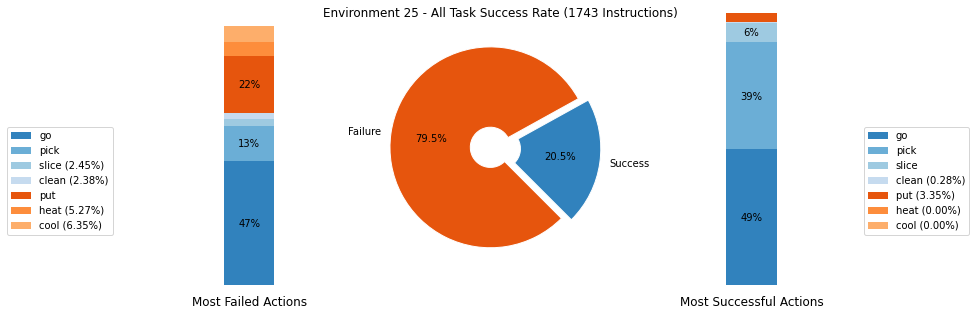

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

success = instruction_success

print("Tasks: ", len(subset))
print("Trajectories: ", len(trajectory_success))
print("Instructions: ", len(instruction_success))

succ_sum = 0
for i in success:
    succ_sum += i[0]

save_figures = True

"""
plt.close()
plt.figure()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax = sns.lineplot(data=reward,palette='Set1')
ax.set(xlabel='Timesteps', ylabel='Reward (Higher is better)')
plt.title('Environment 25 All Instructions')
plt.tight_layout()
if save_figures:
    plt.savefig('dotnet-environment25-instructions-reward.pdf', dpi=300, bbox_inches='tight')
"""

plt.figure()

action_failure = {}
action_success = {}

for i in success:
    if not i[1] in action_success:
        action_success[i[1]] = 0.0
    if not i[1] in action_failure:
        action_failure[i[1]] = 0.0
    if i[0] == 1.0:
        action_success[i[1]] += 1.0
    else:
        action_failure[i[1]] += 1.0

action_list = list(action_success.keys())

print('Failure: ', action_failure)
print('Success: ', action_success)

# make figure and assign axis objects
fig = plt.figure(figsize=(9+4.5, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
fig.subplots_adjust(wspace=0)

size = 0.2
vals = np.array([list(action_success.values()), list(action_failure.values())])
print(vals)

cmap = plt.get_cmap("tab20c")
pie_colors = cmap(np.arange(3)*4)
bar_colors = cmap(np.arange(8))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / np.sum(vals[1]) for i in vals[1]] #Failure values
width = .2
fail_labels = action_list[:]

for j in range(len(ratios)):
    height = ratios[j]
    ax1.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax1.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.1:
        ax1.text(xpos, ypos - 0.015, "%d%%" % (ax1.patches[j].get_height() * 100),
                 ha='center')
    else:
        fail_labels[j] = "{} ({:.2f}%)".format(fail_labels[j], ratios[j] * 100.0)

ax1.set_title('Most Failed Actions', y=-0.1)
ax1.legend(fail_labels, bbox_to_anchor=(0,0.25), loc="lower left",  bbox_transform=fig.transFigure)
ax1.axis('off')
ax1.set_xlim(- 2.5 * width, 2.5 * width)

# pie chart parameters
ax2.pie(vals.sum(axis=1), explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
        shadow=False, startangle=-45, radius=1., colors=pie_colors, wedgeprops=dict(width=0.8, edgecolor='w'))

ax2.set(title='Environment 25 - All Task Success Rate (%d Instructions)' % len(success))

# bar chart parameters
xpos = 0
bottom = 0
ratios = [i / succ_sum for i in vals[0]] #Success values
width = .2

for j in range(len(ratios)):
    height = ratios[j]
    ax3.bar(xpos, height, width, bottom=bottom, color=bar_colors[j], ecolor='w')
    ypos = bottom + ax3.patches[j].get_height() / 2.
    bottom += height
    if ratios[j] > 0.05:
        ax3.text(xpos, ypos - 0.015, "%d%%" % (ax3.patches[j].get_height() * 100),
                 ha='center')
    else:
        action_list[j] = "{} ({:.2f}%)".format(action_list[j], ratios[j] * 100.0)

ax3.set_title('Most Successful Actions', y=-0.1)
ax3.legend(action_list, bbox_to_anchor=(1,0.25), loc="lower right",  bbox_transform=fig.transFigure)
ax3.axis('off')
ax3.set_xlim(- 2.5 * width, 2.5 * width)

#plt.tight_layout()
if save_figures:
    plt.savefig('dotnet-environment25-instructions-success.png', dpi=300, bbox_inches='tight')


#fig, ax = plt.subplots()
#ax.pie([succ_sum, len(success) - succ_sum], explode=(0.0,0.1), labels=('Success', 'Failure'), autopct='%1.1f%%',
#        shadow=False, startangle=45)
#ax.axis('equal')
#plt.title('Environment 25 - All Task Success Rate (%d Instructions)' % len(success))
#if save_figures:
#    plt.savefig('dotnet(cosine,no punc,no unfound object graphs)-environment25-full_trajectories-pickup-success-rate.pdf', dpi=300, bbox_inches='tight')

In [ ]:
import pandas as pd
import cv2
import pathlib

#=========================================================
#import torchtext

# Load FastText word vectors
#fast_text = torchtext.vocab.FastText(cache='../.vector_cache')

# Load ALFRED training data using torchtext
import torchtext.data as data

#  Basic english normalisation, lowers and seperates grammar
INSTRUCTION = data.Field(tokenize='basic_english', lower=True,
                         init_token='<sos>',
                         eos_token='<eos>',)
ACTION = data.Field(is_target=True)
ACTION_ARGUMENT_1 = data.Field(tokenize='basic_english',is_target=True)
ACTION_ARGUMENT_2 = data.Field(tokenize='basic_english',is_target=True)

ALFRED_DATA_ROOT = '../honours_research_repo/'
ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Train_InstActionArgs.tsv'
ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Validation_InstActionArgs.tsv'
ALFRED_TEST_INSTRUCTION_TSV_FILENAME = ALFRED_DATA_ROOT + 'ALFRED_Test_InstActionArgs.tsv'

def filter_action(example):
    if example.action[0] == 'PickupObject':
        return True
    else:
        return False

train, val, test = data.TabularDataset.splits(
    path='', 
    train=ALFRED_TRAIN_INSTRUCTION_TSV_FILENAME,
    validation=ALFRED_VALIDATION_INSTRUCTION_TSV_FILENAME,
    test=ALFRED_TEST_INSTRUCTION_TSV_FILENAME, format='tsv',
    fields=[('trajectory_number', None),
            ('task_description', None),
            ('instruction_number', None),
            ('instruction', INSTRUCTION),
            ('action', ACTION),
            ('action_argument_1', ACTION_ARGUMENT_1),
            ('action_argument_2', ACTION_ARGUMENT_2)
           ], 
    filter_pred=filter_action)

INSTRUCTION.build_vocab(train,vectors=__word_vec__) #'fasttext.en.300d')
ACTION.build_vocab(train)
ACTION_ARGUMENT_1.build_vocab(train,vectors=__word_vec__)
ACTION_ARGUMENT_2.build_vocab(train,vectors=__word_vec__)
#=========================================================